# Diffusers Poject

---

## Memory가 부족해서 Openpose & Canny 이미지를 전처리기로 따로 생성/저장해서 

## DiffuserControlNet으로 합성 하였습니다

## AIFFEL On 6기 최현우

In [1]:
!pip install --upgrade -qq git+https://github.com/huggingface/diffusers.git transformers accelerate

In [5]:
# GPU 메모리를 지우는 코드입니다.
import torch
torch.cuda.empty_cache()

In [12]:
# 메모리 효율적인 어텐션 메커니즘을 활성화하는 기능을 제공
# !pip install xformers

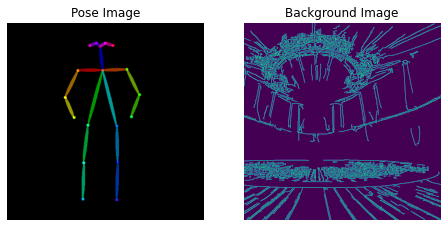

In [33]:
import matplotlib.pyplot as plt
from PIL import Image

pose_image_path = '/aiffel/aiffel/diffusers/human_pose.png'  # 포즈 추출 이미지 경로
background_image_path = '/aiffel/aiffel/diffusers/back_canny_edges.png'  # 배경 윤곽선 이미지 경로

pose_image = Image.open(pose_image_path)
background_image = Image.open(background_image_path)

# 이미지 출력
plt.figure(figsize=(12, 8))

# 첫 번째 이미지 (포즈 추출 이미지)
plt.subplot(1, 3, 1)
plt.imshow(pose_image)
plt.title("Pose Image")
plt.axis("off")

# 두 번째 이미지 (배경 윤곽선 이미지)
plt.subplot(1, 3, 2)
plt.imshow(background_image)
plt.title("Background Image")
plt.axis("off")

plt.show()

In [28]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel, UniPCMultistepScheduler
import torch
from PIL import Image
from torchvision.transforms import ToTensor

# 이미 저장된 포즈 추출 이미지와 배경 윤곽선 이미지를 로드
pose_image_path = '/aiffel/aiffel/diffusers/human_pose.png'  # 포즈 추출 이미지 경로
background_image_path = '/aiffel/aiffel/diffusers/back_canny_edges.png'  # 배경 윤곽선 이미지 경로

openpose_image = Image.open(pose_image_path)
canny_image = Image.open(background_image_path)

# 이미지를 텐서로 변환
transform = ToTensor()
openpose_tensor = transform(openpose_image).to("cuda")
canny_tensor = transform(canny_image).to("cuda")

controlnet = [
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-openpose", torch_dtype=torch.float32),
    ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float32),
]

# StableDiffusionControlNetPipeline 인스턴스 생성
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float32
)

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

# 파이프라인을 GPU로 이동
pipe = pipe.to("cuda")

# pipe.enable_xformers_memory_efficient_attention()
# pipe.enable_model_cpu_offload()

# 프롬프트
prompt = 'A person dancing very excitedly in the middle of a fancy stage. The person is expressed most clearly. The center of the background is filled with people even if the background is erased. A British handsome man with a distinct face..'
negative_prompt = 'Do not make the lighting flashy'

generator = torch.Generator(device="cuda").manual_seed(1)

# 이미지 리스트 생성
images = [openpose_image, canny_image]

image = pipe(
    prompt,
    images,
    num_inference_steps=20,
    generator=generator,
    negative_prompt=negative_prompt,
    controlnet_conditioning_scale=[1.5, 0.4],
).images[0]

image.save("/aiffel/aiffel/diffusers/controlnet_output4.png")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


  0%|          | 0/20 [00:00<?, ?it/s]

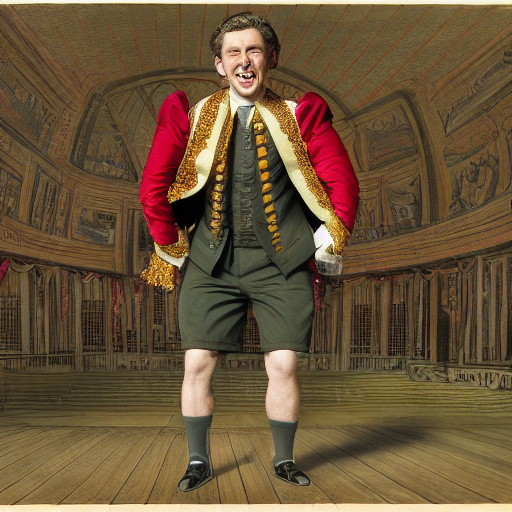

In [29]:
image

# 참고 문헌
### Issue : 컨트롤넷 합성 타입 에러 발생

* https://huggingface.co/blog/controlnet?utm_source=pytorchkr